In [2]:
from scipy.io import loadmat
from scipy.spatial.distance import cdist, euclidean
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data = loadmat('../data/digit-dataset/train.mat')

In [3]:
images = np.reshape(data['train_images'],(784,60000)).transpose().astype('float')
np.random.shuffle(images)
images.shape

(60000, 784)

### 1. K-means Clustering

In [4]:
class k_means:
    def __init__(self, data, k=10, maxiters=100):
        self.k = k
        self.data = data
        self.maxiters = maxiters
        self.kplusplus()
        
    def train(self):
        loss = [] 
        for i in range(self.maxiters):
            old_centroids = self.centroids
            distances = cdist(np.matrix(self.centroids), self.data, 'sqeuclidean')
            clusters = np.argmin(distances, axis=0)
            loss.append((i, np.sum(np.min(distances, axis=0))))
            self.centroids = [np.mean(self.data[clusters == k], axis=0) for k in range(self.k)]
            if np.array_equal(self.centroids, old_centroids):
                return loss
        return loss
    
    def kplusplus(self):
        indxs = range(self.data.shape[0])
        np.random.shuffle(indxs)
        self.centroids = [self.data[indxs.pop()]]
        for i in range(1, self.k):
            distances = cdist(np.matrix(self.centroids), self.data[indxs], 'sqeuclidean')
            distances = np.min(distances, axis=0) / np.sum(np.min(distances, axis=0))
            new_cent = np.random.choice(indxs, p=distances)
            indxs.remove(new_cent)
            self.centroids += [self.data[new_cent]]

### k=5

In [5]:
k_class = k_means(images, k=5, maxiters=1000)

In [6]:
loss5 = k_class.train()

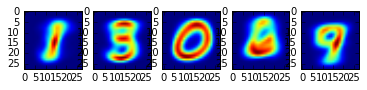

In [7]:
f, axarr = plt.subplots(1, k_class.k)
for i in range(k_class.k):
    axarr[i].imshow(k_class.centroids[i].reshape((28,28)))
plt.show()

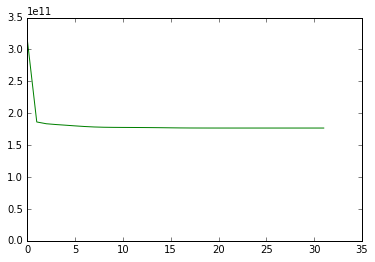

In [8]:
plt.plot(loss5)

### k=10

In [9]:
k_class = k_means(images, k=10, maxiters=1000)
loss10 = k_class.train()

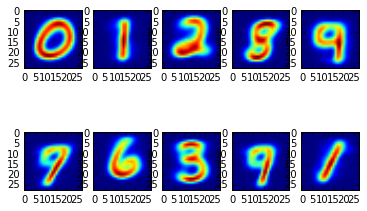

In [10]:
f, axarr = plt.subplots(2, k_class.k / 2)
for i in range(k_class.k / 2):
    axarr[0][i].imshow(k_class.centroids[i].reshape((28,28)))
for i in range(k_class.k / 2):
    axarr[1][i].imshow(k_class.centroids[i+5].reshape((28,28)))

plt.show()

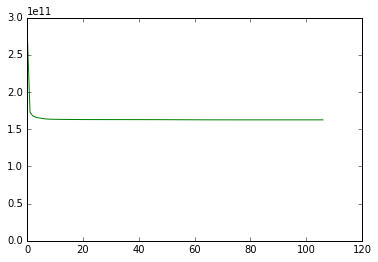

In [11]:
plt.plot(loss10)

### k=20

In [30]:
k_class = k_means(images, k=20, maxiters=1000)
loss20 = k_class.train()

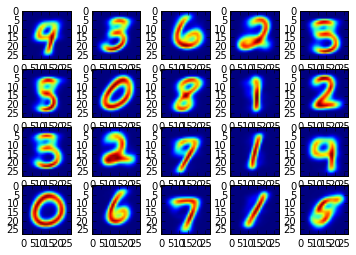

In [31]:
f, axarr = plt.subplots(4, k_class.k / 4)
offset = 0
for j in range(4):
    for i in range(k_class.k / 4):
        axarr[j][i].imshow(k_class.centroids[i+offset].reshape((28,28)))
    offset += 5
plt.show()

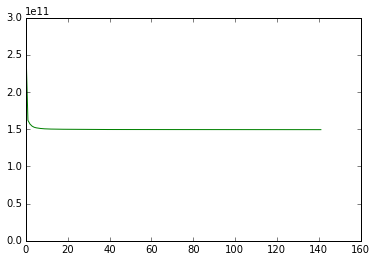

In [32]:
plt.plot(loss20)

### k=5 multiple random initialization

In [119]:
losses = []
for i in range(5):
    k_class = k_means(images, k=5, maxiters=1000)
    losses.append(k_class.train())
    

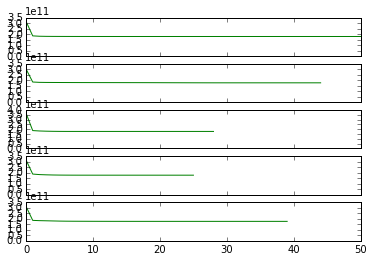

In [120]:
f, axarr = plt.subplots(5, 1, sharex=True)
for i in range(5):
    axarr[i].plot(losses[i])
plt.show()

### 2. Joke Recommender System

In [12]:
data = loadmat('../data/joke-dataset/joke_train.mat')
jokeMatrix = data['train']

In [14]:
# validation data
valJokes = []
with open('../data/joke-dataset/validation.txt', 'rb') as file:
    for line in file:
        row = [float(x) for x in line.strip().split(',')]
        valJokes.append(row)
valJokes = np.array(valJokes)

In [15]:
def accuracy(pred, true):
    hits = [1 if (p == t) else 0 for p,t in zip(pred,true)]
    return np.mean(hits)

### Naive Joker - Average

In [16]:
class naiveJoker():
    def __init__(self):
        self.averageRatings = None
    
    def train(self, jokeMatrix):
        self.averageRatings = np.nanmean(jokeMatrix, axis=0)
    
    def predict(self, query):
        if self.averageRatings is None:
            print 'I havent learned any jokes, train me! :('
            return
        predictions = [1 if (self.averageRatings[int(query[i][1])-1] >= 0) else 0 for i in range(query.shape[0])]
        return np.array(predictions)

In [17]:
bozo = naiveJoker()
bozo.train(jokeMatrix)

In [18]:
bozo_preds = bozo.predict(valJokes)

#### Naive Accuracy

In [19]:
print 'Bozo made laugh ' + str(accuracy(bozo_preds, valJokes[:,2].astype('int'))) + '% of the audience.'

Bozo made laugh 0.620325203252% of the audience.


### kNN Joker

In [20]:
class knnJoker():
    def __init__(self, k=10):
        self.k = k
        
    def train(self, jokeMatrix):
        self.Ratings = np.nan_to_num(jokeMatrix)
    
    def predict(self, query):
        predictions = []
        users = {}
        for user_indx, joke_indx in query[:,:2]:
            if user_indx in users:
                avgRatings = users[int(user_indx)]
                predictions.append(1 if (avgRatings[int(joke_indx)-1] >= 0) else 0)
            else:
                user = self.Ratings[int(user_indx) - 1]
                distances = cdist(np.matrix(user), self.Ratings, 'euclidean')
                kneighbors = np.argsort(distances, axis=None)[1:self.k+1]
                avgRatings = np.mean(self.Ratings[kneighbors], axis=0)
                users[int(user_indx)] = avgRatings
                predictions.append(1 if (avgRatings[int(joke_indx)-1] >= 0) else 0)
        
        return np.array(predictions)

### Accuracies for multiple values of k

In [11]:
kList = [10, 100, 1000, 10000, 20000]
for k_ in kList:
    pogo = knnJoker(k=k_)
    pogo.train(jokeMatrix)
    pogo_preds = pogo.predict(valJokes)
    print 'Pogo made laugh ' + str(accuracy(pogo_preds, valJokes[:,2].astype('int'))) \
        +'% of the audience using k = ' + str(k_) +'.'

Pogo made laugh 0.647967479675% of the audience using k = 10.
Pogo made laugh 0.689972899729% of the audience using k = 100.
Pogo made laugh 0.694037940379% of the audience using k = 1000.
Pogo made laugh 0.669647696477% of the audience using k = 10000.
Pogo made laugh 0.646883468835% of the audience using k = 20000.


We can see that using 1000 nearest neighbors increases the accuracy, but as we keep increasing k at some point it starts decreasing again. This makes sense since by increasing the nearest neighbors we are slowly approaching the naive case where we average amongst all our data.